# Dimensionality Reduction

#### 개요
- Mnist 데이터를 사용 (8:2 비율로 train set, test set split) 
- 원본 데이터 & PCA 축소 데이터 & LDA 축소 데이터 비교 
- 지금까지 배웠던 다항 분류기 2개 이상 사용 (KNN, random forest, NB 등등) 
- time stamp 찍어서 training 시간과 test accuracy 비교하기

#### 데이터 출처
Mnist 데이터

In [99]:
# 데이터 로드
import numpy as np
import pandas as pd
from scipy import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
mnist = io.loadmat('mnist-original.mat') 
X = mnist['data'].T
y = mnist['label'].T

print (X.shape, y.shape)
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y.astype(int)

# 데이터 로드와 df로 만드는 코드는 강의자님의 실습파일을 사용했습니다. 

(70000, 784) (70000, 1)


## Mnist data split
* train, test split - 8:2


In [100]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
train_set, test_set = train_test_split(df, test_size=0.2, random_state=1)

# 정규화, standardscaler보다 pca결과가 좋은 것 같아서 사용했습니다
sc = MinMaxScaler()
train_x = train_set.iloc[:,:-1]
train_x = pd.DataFrame(sc.fit_transform(train_x), columns=train_x.columns.values, index=train_x.index.values)
train_y = train_set['label']

test_x = test_set.iloc[:,:-1]
test_x = pd.DataFrame(sc.transform(test_x), columns=test_x.columns.values, index=test_x.index.values)
test_y = test_set['label']
print(train_x.shape)
train_x.head()

(56000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
57050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## PCA & LDA

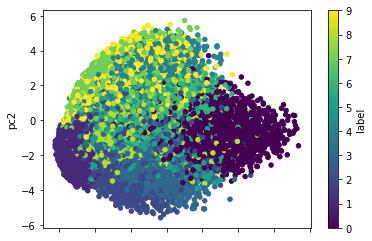

In [101]:
# 일단 시각화
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

model = PCA(n_components=2)
pca_2d = pd.DataFrame(model.fit_transform(train_x.values), columns=['pc1','pc2'])
pca_2d = pd.concat([pca_2d, train_y.reset_index()['label']],axis=1)
ax = pca_2d.plot.scatter(x='pc1', y='pc2', c='label', colormap='viridis')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


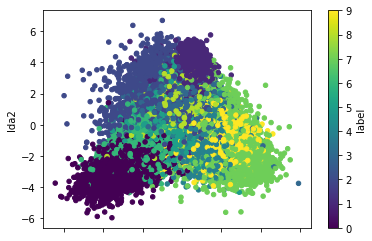

In [73]:
#일단 시각화
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
LDA = pd.DataFrame(lda.fit_transform(train_x.values, train_y.values), columns=['lda1','lda2'])
LDA = pd.concat([LDA, train_y.reset_index()['label']],axis=1)
ax = LDA.plot.scatter(x='lda1', y='lda2', c='label', colormap='viridis')

* PCA와 LDA시각화를 위해 둘 다 2차원으로 고정시켰습니다.
* 위치나 모양은 다르지만 9와 8이 비슷하게 묶이는 등 숫자들을 인식하는 것은 둘 다 비슷해 보입니다.
* 이제 모델을 만들고 성능 측정을 하겠습니다.

In [102]:
# eigen-value고려한 pca

cov_mat = np.cov(train_x.T) # 공분산 행렬을 생성, feature들이 행 쪽에 있어야 해서 T를 해줌
eigen_vals, eigen_vectors = np.linalg.eig(cov_mat) # eig는 eigen value, vector 두 개를 반환해줌
tot = sum(eigen_vals)
ev_li = [i for i in eigen_vals if i > 1]
var_exp = [(i / tot) for i in ev_li]
cum_var_exp = np.cumsum(var_exp) # 누적 합을 계산해주는 함수. -> 누적 백분위로 표현

print(len(ev_li))
print(f'eigen-values : {ev_li}')
print(f'설명률 : {var_exp}')
print(f'누적 : {cum_var_exp[-1:]}')


12
eigen-values : [5.139203572013698, 3.7720773380154284, 3.231074154478527, 2.8545390994285493, 2.585820703450385, 2.269871146677216, 1.7340998875526545, 1.5227945097325115, 1.456231160878074, 1.2427466783873045, 1.1060868024422508, 1.0729863963914636]
설명률 : [0.09742953344423273, 0.0715114180648042, 0.06125502579988528, 0.05411663670421004, 0.04902224657523981, 0.043032443393292624, 0.03287523847274857, 0.028869290063274083, 0.02760737546259746, 0.02356011536962761, 0.02096930382318867, 0.020341783026794298]
누적 : [0.53059041]


* eigen value를 구하기 위해 공분산 행렬 cov_mat을 만듭니다
* eigen value가 1이 넘는 feature의 개수는 12개 입니다.
* 그런데 12개 총 누적설명률이 0.53입니다. 

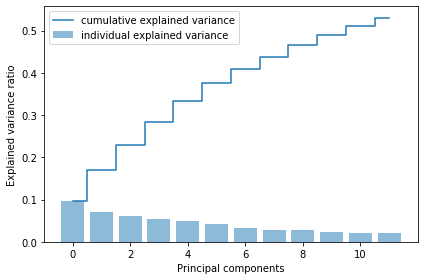

In [103]:
# eigen value  1넘는 친구들만 plot에 찍어보기
plt.bar(range(12), var_exp[:12], alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(12), cum_var_exp[:12], where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [104]:
from sklearn.decomposition import PCA

# n을 1 이상의 자연수로 정해주면 개수를 정하는 것이고, 0~1사이 소수점은 누적설명률을 만족하는 최소개수를 구함
pca = PCA(n_components=.7)
train_pca = pca.fit_transform(train_x.values)
print(train_pca.shape)
print(pca.explained_variance_ratio_)
pca_train = pd.DataFrame(train_pca)
pca_train.head()

(56000, 26)
[0.09742953 0.07151142 0.06125503 0.05411664 0.04902225 0.04303244
 0.03287524 0.02886929 0.02760738 0.02356012 0.0209693  0.02034178
 0.01703075 0.01699426 0.01583653 0.01489118 0.01321716 0.01284798
 0.01183029 0.01154095 0.01069969 0.01006495 0.00957949 0.00911695
 0.00884086 0.00835452]


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,-1.768455,1.481691,-1.484926,-0.746108,0.889216,-2.012906,-0.085984,-1.770059,0.918057,2.273451,...,0.627033,0.408905,-0.387397,-0.699214,1.667866,0.491899,0.734332,0.039874,0.919452,-0.394170
1,0.124754,1.786762,-0.699600,4.100948,-1.500456,-0.585224,-0.494991,1.602286,-0.060982,0.151791,...,-0.968917,0.611175,1.161660,1.025012,0.223301,-1.205593,-0.277529,0.928650,0.289752,-1.724973
2,5.394160,0.019679,-2.002807,2.316630,-2.253617,2.399048,3.212604,-2.041855,0.953096,0.928530,...,-2.319599,-0.113329,-0.678589,-0.625236,-0.609213,-0.460151,-0.443008,0.909812,0.222104,-0.569408
3,-3.319002,-1.920219,-0.049667,1.006499,-2.140209,-0.384879,-0.504207,-0.485956,0.329483,0.059899,...,-0.432521,-0.169218,-0.766166,0.179130,0.156583,0.388596,0.161402,-0.143185,-0.330683,-0.730177
4,0.770580,-0.650988,2.212258,-2.015932,-1.183646,-1.119040,-0.294374,2.825879,1.464738,0.209891,...,0.228862,-0.302649,0.160057,0.823876,1.117363,0.902726,-1.094214,-0.160064,-0.806405,0.407149


* eigen value > 1은 12개인데 누적설명률 70이 넘는게 26개... 괴리가 존재합니다
* 일단 26개로 하겠습니다

In [105]:
test_pca = pca.transform(test_x.values)
print(test_pca.shape)
pca_test = pd.DataFrame(test_pca)
pca_test.head()

(14000, 26)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,-3.740362,-1.091169,-0.245638,-0.072679,-1.950517,-1.152180,1.395156,-0.747386,-0.161941,0.520330,...,0.838756,-0.406441,-0.326277,0.169129,-0.015064,0.181093,0.764834,0.067929,-0.800220,0.433408
1,-1.151045,-1.406521,0.952487,-1.722590,2.679138,-1.546650,1.633198,-0.692413,0.130372,1.592190,...,-0.439074,-1.022010,0.191805,-0.148322,0.300582,-0.651106,-1.113644,-0.768779,1.405477,-0.286848
2,0.444039,-3.385777,-1.655720,-0.131719,2.061211,0.168519,-0.773299,-0.100331,-0.459229,0.715379,...,-0.213067,-0.079576,-0.046233,0.063863,-0.859073,2.348818,-1.162522,-0.182163,0.551175,0.887118
3,-1.281592,-1.987813,-3.364436,-0.441361,-0.466189,-1.313269,-1.226457,0.501369,0.315152,-1.021737,...,0.800541,1.045332,-0.401684,-0.660794,-0.242504,-0.510952,-0.840120,-0.393206,-1.399102,-0.106426
4,-0.279545,-1.165437,3.090803,-1.934270,2.294037,0.949924,-0.843105,-1.110449,-0.439212,0.579503,...,-0.858362,-0.864871,0.476276,1.275226,-0.139853,0.892875,-1.136299,0.498859,-0.255912,0.702361


In [106]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time



KNN = KNeighborsClassifier()
parameters = {'n_neighbors': [3,5,7,9],
              'n_jobs': [None, -1],
              }

model = GridSearchCV(KNN, param_grid=parameters)
grid = model.fit(pca_train, train_y)
print(f'score: {grid.best_score_}')
print(f'params: {grid.best_params_}')
print(f'estimator: {grid.best_estimator_}')
KNN = grid.best_estimator_

t0 = time()

predicted = KNN.fit(pca_train, train_y).predict(pca_test)
accuracy = accuracy_score(test_y, predicted)
print(f'accuracy: {accuracy:.3}')
print(f'cross val score: {cross_val_score(KNN, pca_train, train_y, cv=5).mean(): .3}')

print("소요된 시간 : %0.3fs" % (time() - t0))


score: 0.971625
params: {'n_jobs': None, 'n_neighbors': 5}
estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
accuracy: 0.974
cross val score:  0.973
소요된 시간 : 149.331s


In [20]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
param_grid = {'min_samples_split' : [2, 5, 10],
             'min_samples_leaf' : [1, 2, 4],
             'n_jobs' : [None, 1]}

model = GridSearchCV(rf, param_grid=param_grid)
grid = model.fit(pca_train, train_y)
print(f'score: {grid.best_score_}')
print(f'params: {grid.best_params_}')
print(f'estimator: {grid.best_estimator_}')
KNN = grid.best_estimator_

t0 = time()

predicted = rf.fit(pca_train, train_y).predict(pca_test)
accuracy = accuracy_score(test_y, predicted)
print(f'accuracy: {accuracy:.3}')
print(f'cross val score: {cross_val_score(rf, pca_train, train_y, cv=5).mean(): .3}')

print("소요된 시간 : %0.3fs" % (time() - t0))

score: 0.9232142857142858
params: {'min_samples_leaf': 1, 'min_samples_split': 5, 'n_jobs': 1}
estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
accuracy: 0.93
cross val score:  0.925
소요된 시간 : 29.207s


In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(random_state=0)
AB = AdaBoostClassifier(base_estimator=DT, n_estimators=500, 
                          learning_rate=0.1)
param_grid ={
    "n_estimators" : [10, 20, 30, 50],
    "learning_rate" : [.1, .4, .7]
    }

model = GridSearchCV(AB, param_grid=param_grid)
grid = model.fit(pca_train, train_y)
print(f'score: {grid.best_score_}')
print(f'params: {grid.best_params_}')
print(f'estimator: {grid.best_estimator_}')
AB = grid.best_estimator_

t0 = time()

predicted = AB.fit(pca_train, train_y).predict(pca_test)
accuracy = accuracy_score(test_y, predicted)
print(f'accuracy: {accuracy:.3}')
print(f'cross val score: {cross_val_score(AB, pca_train, train_y, cv=5).mean(): .3}')

print("소요된 시간 : %0.3fs" % (time() - t0))

score: 0.8351071428571428
params: {'learning_rate': 0.1, 'n_estimators': 50}
estimator: AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
              

In [28]:
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()

t0 = time()

predicted = NB.fit(pca_train, train_y).predict(pca_test)
accuracy = accuracy_score(test_y, predicted)
print(f'accuracy: {accuracy:.3}')
print(f'cross val score: {cross_val_score(NB, pca_train, train_y, cv=5).mean(): .3}')

print("소요된 시간 : %0.3fs" % (time() - t0))

accuracy: 0.859
cross val score:  0.855
소요된 시간 : 0.893s


In [29]:
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)

params ={
    'loss' : ['deviance', 'exponential'],
    "n_estimators" : [10, 20, 30, 50, 100],
    'subsample' : [.2, .6, 1],
    'max_depth' : [1, 2, 3],
    "learning_rate" : [.1, .4, .7]}

model = GridSearchCV(GB, param_grid=param_grid)
grid = model.fit(pca_train, train_y)
print(f'score: {grid.best_score_}')
print(f'params: {grid.best_params_}')
print(f'estimator: {grid.best_estimator_}')
GB = grid.best_estimator_

t0 = time()

predicted = GB.fit(pca_train, train_y).predict(pca_test)
accuracy = accuracy_score(test_y, predicted)
print(f'accuracy: {accuracy:.3}')
print(f'cross val score: {cross_val_score(GB, pca_train, train_y, cv=5).mean(): .3}')

print("소요된 시간 : %0.3fs" % (time() - t0))

score: 0.9230357142857143
params: {'learning_rate': 0.4, 'n_estimators': 50}
estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.4, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
accuracy: 0.929
cross val score:  0.926
소요된 시간 : 887.145s


In [108]:
from lightgbm import LGBMClassifier
LGB = LGBMClassifier()
param_grid = {
            'num_leaves' : [2,5,10],
            'learning_rate': [0.01, 0.1, 0.5, 1],
            'n_estimators': [20, 40, 60, 80, 100]
            }
model = GridSearchCV(LGB, param_grid=param_grid)
grid = model.fit(pca_train, train_y)
print(f'score: {grid.best_score_}')
print(f'params: {grid.best_params_}')
print(f'estimator: {grid.best_estimator_}')
LGB = grid.best_estimator_

t0 = time()

predicted = LGB.fit(pca_train, train_y).predict(pca_test)
accuracy = accuracy_score(test_y, predicted)
print(f'accuracy: {accuracy:.3}')
print(f'cross val score: {cross_val_score(LGB, pca_train, train_y, cv=5).mean(): .3}')

print("소요된 시간 : %0.3fs" % (time() - t0))

score: 0.9249821428571429
params: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 10}
estimator: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=10, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
accuracy: 0.927
cross val score:  0.925
소요된 시간 : 47.013s


## LDA

In [97]:
lda = LinearDiscriminantAnalysis(n_components=len(list(df['label'].unique()))-1)
lda_train = lda.fit_transform(train_x.values, train_y.values)
lda_test = lda.transform(test_x.values)
lda_train.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(56000, 9)

In [86]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time

KNN = KNeighborsClassifier()
parameters = {'n_neighbors': [3,5,7,9],
              'n_jobs': [None, -1],
              }

model = GridSearchCV(KNN, param_grid=parameters)
grid = model.fit(lda_train, train_y)
print(f'score: {grid.best_score_}')
print(f'params: {grid.best_params_}')
print(f'estimator: {grid.best_estimator_}')
KNN = grid.best_estimator_

t0 = time()

predicted = KNN.fit(lda_train, train_y).predict(lda_test)
accuracy = accuracy_score(test_y, predicted)
print(f'accuracy: {accuracy:.3}')
print(f'cross val score: {cross_val_score(lda, lda_train, train_y, cv=5).mean(): .3}')

print("소요된 시간 : %0.3fs" % (time() - t0))

score: 0.9198035714285714
params: {'n_jobs': None, 'n_neighbors': 9}
estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')
accuracy: 0.92
cross val score:  0.873
소요된 시간 : 7.317s


In [88]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
param_grid = {'min_samples_split' : [2, 5, 10],
             'min_samples_leaf' : [1, 2, 4],
             'n_jobs' : [None, 1]}

model = GridSearchCV(rf, param_grid=param_grid)
grid = model.fit(lda_train, train_y)
print(f'score: {grid.best_score_}')
print(f'params: {grid.best_params_}')
print(f'estimator: {grid.best_estimator_}')
KNN = grid.best_estimator_

t0 = time()

predicted = rf.fit(lda_train, train_y).predict(lda_test)
accuracy = accuracy_score(test_y, predicted)
print(f'accuracy: {accuracy:.3}')
print(f'cross val score: {cross_val_score(rf, lda_train, train_y, cv=5).mean(): .3}')

print("소요된 시간 : %0.3fs" % (time() - t0))

score: 0.905125
params: {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_jobs': None}
estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
accuracy: 0.904
cross val score:  0.906
소요된 시간 : 18.499s


In [89]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(random_state=0)
AB = AdaBoostClassifier(base_estimator=DT, n_estimators=500, 
                          learning_rate=0.1)
param_grid ={
    "n_estimators" : [10, 20, 30, 50],
    "learning_rate" : [.1, .4, .7]
    }

model = GridSearchCV(AB, param_grid=param_grid)
grid = model.fit(lda_train, train_y)
print(f'score: {grid.best_score_}')
print(f'params: {grid.best_params_}')
print(f'estimator: {grid.best_estimator_}')
AB = grid.best_estimator_

t0 = time()

predicted = AB.fit(lda_train, train_y).predict(lda_test)
accuracy = accuracy_score(test_y, predicted)
print(f'accuracy: {accuracy:.3}')
print(f'cross val score: {cross_val_score(AB, lda_train, train_y, cv=5).mean(): .3}')

print("소요된 시간 : %0.3fs" % (time() - t0))

score: 0.8548571428571429
params: {'learning_rate': 0.7, 'n_estimators': 30}
estimator: AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
              

In [90]:
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()

t0 = time()

predicted = NB.fit(lda_train, train_y).predict(lda_test)
accuracy = accuracy_score(test_y, predicted)
print(f'accuracy: {accuracy:.3}')
print(f'cross val score: {cross_val_score(NB, lda_train, train_y, cv=5).mean(): .3}')

print("소요된 시간 : %0.3fs" % (time() - t0))

accuracy: 0.88
cross val score:  0.882
소요된 시간 : 0.449s


In [91]:
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)

params ={
    'loss' : ['deviance', 'exponential'],
    "n_estimators" : [10, 20, 30, 50, 100],
    'subsample' : [.2, .6, 1],
    'max_depth' : [1, 2, 3],
    "learning_rate" : [.1, .4, .7]}

model = GridSearchCV(GB, param_grid=param_grid)
grid = model.fit(lda_train, train_y)
print(f'score: {grid.best_score_}')
print(f'params: {grid.best_params_}')
print(f'estimator: {grid.best_estimator_}')
GB = grid.best_estimator_

t0 = time()

predicted = GB.fit(lda_train, train_y).predict(lda_test)
accuracy = accuracy_score(test_y, predicted)
print(f'accuracy: {accuracy:.3}')
print(f'cross val score: {cross_val_score(GB, lda_train, train_y, cv=5).mean(): .3}')

print("소요된 시간 : %0.3fs" % (time() - t0))

score: 0.8979107142857143
params: {'learning_rate': 0.4, 'n_estimators': 50}
estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.4, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
accuracy: 0.897
cross val score:  0.899
소요된 시간 : 342.161s


In [93]:
from lightgbm import LGBMClassifier
LGB = LGBMClassifier()
param_grid = {
            'num_leaves' : [2,5,10],
            'learning_rate': [0.01, 0.1, 0.5, 1],
            'n_estimators': [20, 40, 60, 80, 100]
            }
model = GridSearchCV(LGB, param_grid=param_grid)
grid = model.fit(lda_train, train_y)
print(f'score: {grid.best_score_}')
print(f'params: {grid.best_params_}')
print(f'estimator: {grid.best_estimator_}')
LGB = grid.best_estimator_

t0 = time()

predicted = LGB.fit(lda_train, train_y).predict(lda_test)
accuracy = accuracy_score(test_y, predicted)
print(f'accuracy: {accuracy:.3}')
print(f'cross val score: {cross_val_score(LGB, lda_train, train_y, cv=5).mean(): .3}')

print("소요된 시간 : %0.3fs" % (time() - t0))

score: 0.906625
params: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 10}
estimator: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=10, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
accuracy: 0.905
cross val score:  0.907
소요된 시간 : 24.327s


* 전체적으로 pca가 더 좋은 결과를 보여주었습니다. 물론 26개의 pca에 비해 LDA가 9개의 차원으로 가성비 좋은 성능을 보여주었습니다.